# Develop: Guidestar selection WALOP-S

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from astropy.coordinates import Angle, SkyCoord
import astropy.units as u
from astropy.io.votable import parse
import matplotlib.pyplot as plt
import numpy as np
import os
from pandas import DataFrame
import seaborn as sns

from fieldgrid import FieldGridIsoLat
from utilities import cart_to_sphere, sphere_to_cart, rot_dec, rot_ra, rot_tilt, inside_polygon, close_to_edge

Helper functions:

In [3]:
def load_gaia(votable_files, dir_in):
    
    if isinstance(votable_files, str):
        votable_files = [votable_files]
        
    gaia_ra = []
    gaia_dec = []
    gaia_mag = []

    for i, filename in enumerate(votable_files, start=1):
        print(f'Read VOTable {i}/{len(votable_files)}..')
        votable = parse(os.path.join(dir_in, filename))
        table = votable.get_first_table()
        sel = table.array['dec'] < 1
        gaia_ra.append(table.array['ra'].data[sel])
        gaia_dec.append(table.array['dec'].data[sel])
        gaia_mag.append(table.array['phot_g_mean_mag'].data[sel])

    gaia_ra = np.concatenate(gaia_ra)
    gaia_dec = np.concatenate(gaia_dec)
    gaia_mag = np.concatenate(gaia_mag)
    
    return gaia_ra, gaia_dec, gaia_mag

In [4]:
def plot_circle(circle_center, radius, **kwargs):
    """Plot a circle."""
    circle = plt.Circle(circle_center, radius, fill=False, **kwargs)
    plt.gca().add_artist(circle)
    plt.gca().set_aspect(1)
    plt.xlim(circle_center[0]-radius*1.1, circle_center[0]+radius*1.1)
    plt.ylim(circle_center[1]-radius*1.1, circle_center[1]+radius*1.1)

In [5]:
def plot_instrumentfield(circle_center, radius):
    """Plot the instrument field."""
    plot_circle(circle_center, radius, edgecolor='k')
    plt.plot(circle_center[0], circle_center[1], marker='+', ms=10, color='k')

In [6]:
def plot_rectangle(rectangle_center, size, **kwargs):
    """Plot a rectangle."""
    rectangle = plt.Rectangle((rectangle_center[0]-size/2, rectangle_center[1]-size/2), size, size, fill=False, **kwargs)
    plt.gca().add_artist(rectangle)

In [7]:
def plot_sciencefield(field_center, size):
    """Plot the science field."""
    plot_rectangle(field_center, size, color='0.5')
    plt.plot(field_center[0], field_center[1], color='0.5', marker='+', ms=10)

In [8]:
def plot_polygon(polygon, **kwargs):
    """Plot a polygon."""
    for ((x0, y0), (x1, y1)) in zip(polygon, np.r_[polygon[1:], [polygon[0]]]):
        plt.plot([x0, x1], [y0, y1], **kwargs)

In [9]:
def plot_patrollingfield(polygon):
    """Plot the guider patrolling field."""
    plot_polygon(polygon, linestyle='-', color='orange')

## Read in Gaia stars

In [10]:
dir_in = 'gaia/'
votable_files = 'gaia_g_mag12_b28.vot'

gaia_ra, gaia_dec, gaia_mag = load_gaia(votable_files, dir_in)
gaia_coord = SkyCoord(gaia_ra, gaia_dec, unit='deg')

print('# stars:', gaia_mag.shape[0])

Read VOTable 1/1..
# stars: 419381


In [11]:
DataFrame({'mag': gaia_mag}).describe()

,mag
count,419381.000000
mean,10.806376
std,1.121649
min,1.773280
25%,10.309081
50%,11.137020
75%,11.636544
max,12.000000


## Geometry

![Test](info/Guider_S_region.png)

**Questions:**
1. All values in the plot are in mm?
2. How do I convert mm into arcmin? The document under Q3 gives scaling factor 0.23 arcmin/mm. However, at the top the scaling 0.051 arcsec/um is given, which equates to 0.85 arcmin/mm.
3. Which part of the sky can the guide camera see?
    1. The area marked with diagonal solid lines is the area where the guide camera can move. That means the CCD center can be placed anywhere in this region?
    2. The CCD image has a size of 6.4 mm horizontally and 4.75 vertially. This means, if we place the camera center at the right edge of the allowed region of motion, the image will extend 3.2 mm beyond the marked region towards the right.
    3. Similarly, if we place the camera center at the top edge of the allowed region of motion, the image will extend 2.37 mm beyond the marked region towards the top.
    4. However, the region accessible to the guide camera does not extend into the science field, because the science field is blocking that light.
    5. The drawn circle is an absolute limit. Any star further away than 150 mm from the circle center will not be visible.
4. How will this be oriented on the sky? When the instrument is mounted is the guide camera area located North and East of the science field or South and West
5. In the document, Q3 states the patroling area is 2*145*35. This is not correct. It should be 180*35+(180-35)*35.

All values in the plot are given in mm. The conversion factors to get to arcmin or rad are:

In [12]:
scale_arcmin = 0.23 # arcmin / mm
scale_rad = np.radians(scale_arcmin / 60) # rad / mm

The science field is 180 mm x 180 mm (41' x 41'):

In [13]:
field_size = 180 # mm
field_size = Angle(field_size * scale_rad, unit='rad')
field_size.arcmin

41.40000000000001

The circle center is set off by +15 mm in x and y:

In [14]:
offset_mm = 15 # mm
offset = Angle(offset_mm * scale_arcmin, unit='arcmin')
radius = Angle(np.sqrt((180/2+offset_mm)**2*2)*scale_rad, unit='rad')
print(f'{radius.arcmin:.1f} arcmin')

34.2 arcmin


Define polygon that traces the outlines of the guider patrolling field. Note, I tracing the exact outline, but I am cutting off a large part of the top right corner, where the throughput is close to zero. This is why I use two points `(125, 60), (60, 125)` instead of the top right corner point `(125, 125)`:

In [15]:
polygon = [(90, -55), (125, -55), (125, 60), (60, 125), (-55, 125), (-55, 90), (90, 90)] ## mm
polygon_arcmin = np.array(polygon) * scale_arcmin - offset.arcmin
polygon_rad = np.array(polygon) * scale_rad - offset.rad
polygon_arcmin

array([[ 17.25, -16.1 ],
       [ 25.3 , -16.1 ],
       [ 25.3 ,  10.35],
       [ 10.35,  25.3 ],
       [-16.1 ,  25.3 ],
       [-16.1 ,  17.25],
       [ 17.25,  17.25]])

## Demonstration

### Selection of guidestars

Define an arbitrary field center anywhere on the Southern hemisphere:

In [16]:
field_center = SkyCoord(90, -60, unit='deg')
#field_center = SkyCoord(-30, -40, unit='deg')
offset = Angle(15 * scale_rad, unit='rad')
circle_center = SkyCoord(field_center.ra + offset, field_center.dec + offset)

In [17]:
field_center

<SkyCoord (ICRS): (ra, dec) in deg
    (90., -60.)>

In [18]:
circle_center

<SkyCoord (ICRS): (ra, dec) in deg
    (90.0575, -59.9425)>

Select all stars in the circle:

In [19]:
sel = gaia_coord.separation(circle_center) < radius
print('Stars in circle region:', np.sum(sel))
gaia_coord[sel]

Stars in circle region: 67


<SkyCoord (ICRS): (ra, dec) in deg
    [(89.45532853, -60.23317959), (89.87124229, -60.04797051),
     (89.87082488, -60.04764939), (89.74577822, -60.04642682),
     (89.19653326, -60.1253444 ), (89.14683893, -60.13976092),
     (89.1417633 , -60.03599715), (89.11402418, -59.96129667),
     (88.98441354, -59.94348483), (88.9889753 , -59.91109706),
     (89.22400772, -59.95226795), (89.33104422, -59.89827838),
     (89.07571986, -59.90962673), (89.09422087, -59.85011641),
     (89.79573836, -59.89197865), (89.50836943, -59.85565086),
     (89.91296526, -59.82652152), (89.64013039, -59.6678236 ),
     (89.51475875, -59.58171686), (89.09998109, -59.65785016),
     (89.33474735, -59.63202236), (89.92569596, -59.64760482),
     (89.91743865, -60.48154627), (89.39803994, -60.28555645),
     (89.26272918, -60.23907156), (89.06203354, -60.20557026),
     (90.77291171, -60.37908007), (90.11325705, -60.4946764 ),
     (90.31128691, -60.48558554), (90.44572303, -60.32855873),
     (90.62811439, -

Rotate coordinate frame for selected stars such that the instrument center becomes (0, 0):

In [20]:
    def rotate_frame(ra, dec, circle_center, tilt=0):
        """Rotate coordinate frame such that circle center becomes (0, 0)."""
        x, y, z = sphere_to_cart(ra, dec)
        x, y, z = rot_ra(x, y, z, -circle_center.ra.rad)
        x, y, z = rot_dec(x, y, z, -circle_center.dec.rad)
        
        if tilt:
            x, y, z = rot_tilt(x, y, z, tilt)
        
        ra_rot, dec_rot = cart_to_sphere(x, y, z)
        ra_rot = np.where(ra_rot > np.pi, ra_rot-2*np.pi, ra_rot)

        return ra_rot, dec_rot

In [21]:
ra_rot, dec_rot = rotate_frame(gaia_coord[sel].ra.rad, gaia_coord[sel].dec.rad, circle_center)
ra_rot_arcmin = np.degrees(ra_rot) * 60
dec_rot_arcmin = np.degrees(dec_rot) * 60

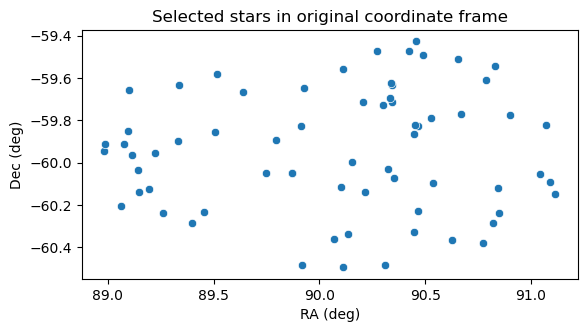

In [22]:
sns.scatterplot(x=gaia_coord[sel].ra.deg, y=gaia_coord[sel].dec.deg)
plt.gca().set_aspect(1)
plt.title('Selected stars in original coordinate frame')
plt.ylabel('Dec (deg)')
plt.xlabel('RA (deg)');

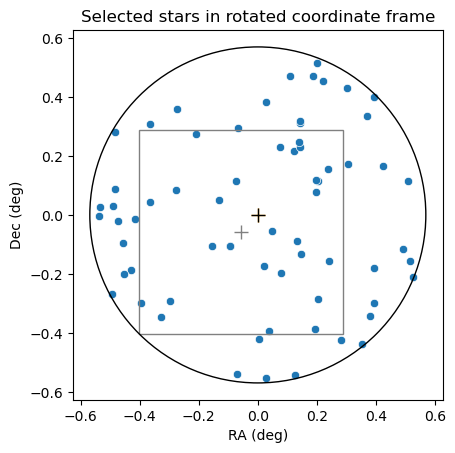

In [23]:
sns.scatterplot(x=np.degrees(ra_rot), y=np.degrees(dec_rot))
plt.plot(0, 0, marker='+', color='orange', ms=10)
plot_sciencefield((-offset.deg, -offset.deg), field_size.deg)
plot_instrumentfield((0, 0), radius.deg)
plt.title('Selected stars in rotated coordinate frame')
plt.ylabel('Dec (deg)')
plt.xlabel('RA (deg)');

Determine which stars are inside the guider patrolling area:

In [24]:
inside = []

for point in zip(ra_rot_arcmin, dec_rot_arcmin):
    inside.append(inside_polygon(point, polygon_arcmin))

Determine if any stars inside the patrolling window are too close to the edge:

In [25]:
limit_arcmin = 1 # arcmin
too_close = []

for point in zip(ra_rot_arcmin[inside], dec_rot_arcmin[inside]):
    too_close.append(close_to_edge(point, polygon_arcmin, limit_arcmin))

In [26]:
labels = np.where(inside, 'in', 'out').astype('U4')
labels[inside] = np.where(too_close, 'edge', labels[inside])

Show result:

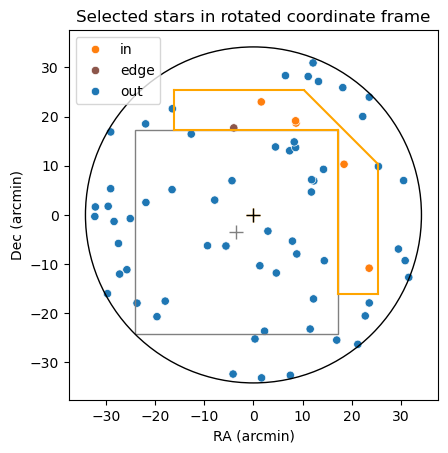

In [27]:
sns.scatterplot(x=ra_rot_arcmin, y=dec_rot_arcmin, hue=labels, hue_order=['in', 'edge', 'out'], palette=['tab:orange', 'tab:brown', 'tab:blue'])
plt.plot(0, 0, marker='+', color='orange', ms=10)
plot_sciencefield((-offset.arcmin, -offset.arcmin), field_size.arcmin)
plot_instrumentfield((0, 0), radius.arcmin)
plot_patrollingfield(polygon_arcmin)
plt.title('Selected stars in rotated coordinate frame')
plt.ylabel('Dec (arcmin)')
plt.xlabel('RA (arcmin)');

**Important note:** When the above is implemented, the close-to-edge limit must also be subtracted from the radius. This was not done in this demonstration.

### Convert magnitudes to exposure time

According to Sid's information we should be able to accuratly guide on a 16 mag star with 5 seconds exposures. The exposure time should then be scaled inversely with flux, which goes as $F \sim 10^{-m/2.5}$, where $m$ is the magnitude. Though, the exposure time should not become arbitrarily short. The minimum should e.g. be 1 second. We use a relation of the following form:

In [28]:
mag = np.linspace(7, 16, 100)
mag_ref = 16
exp_ref = 5 # sec
exp_min = 1 # sec
exp = np.maximum(exp_ref * 10**((mag - mag_ref) / 2.5), exp_min)

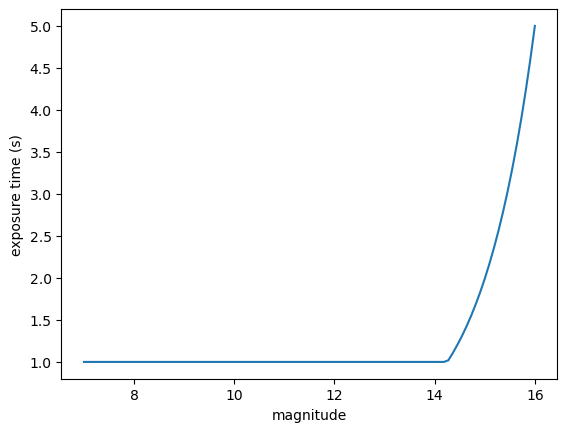

In [29]:
plt.plot(mag, exp)
plt.xlabel('magnitude')
plt.ylabel('exposure time (s)');

## Class implementation

Create guide star selection class:

In [30]:
from guidestars import GuideStarWalopS, load_gaia

In [31]:
selector = GuideStarWalopS()

### Set, save, load parameters

Define parameters:

In [32]:
scale_arcmin = 0.23 # arcmin / mm
scale = np.radians(scale_arcmin / 60) # rad / mm
circle_radius = np.sqrt((180/2+15)**2*2) # mm
circle_offset = 15 # mm
field_size = 180 # mm
cam_size = [6.4, 4.75] # mm
guide_area = [(90, -55), (125, -55), (125, 60), (60, 125), (-55, 125), (-55, 90), (90, 90)] ## mm
instr_rot = 0 # rad
limit_arcmin = 1 # arcmin
limit = limit_arcmin / scale_arcmin
home_pos = (125, 125)
scale_xy = 1 / scale # mm / rad
n_min = 2
n_max = 3

In [33]:
selector.set_params(
        circle_radius, circle_offset, field_size, cam_size, guide_area, home_pos, instr_rot=instr_rot, limit=limit, 
        scale=scale, scale_xy=scale_xy, n_min=n_min, n_max=n_max)

Save/load parameters to/from JSON file:

In [34]:
selector.save_params('guide_walop_s.json')

Guide parameters saved in: guide_walop_s.json


In [35]:
selector.load_params('guide_walop_s.json')

Parameters loaded from guide_walop_s.json.


### Add stars

Load Gaia stars:

In [36]:
dir_in = 'gaia/'
votable_files = 'gaia_g_mag12_b28.vot'

gaia_ra, gaia_dec, gaia_mag = load_gaia(votable_files, dir_in, dec_uplim=1)
gaia_coord = SkyCoord(gaia_ra, gaia_dec, unit='deg')

print('# stars:', gaia_mag.shape[0])

Read VOTable 1/1..
# stars: 419381


Add stars:

In [37]:
selector.set_stars(np.radians(gaia_ra), np.radians(gaia_dec), gaia_mag)

419381 candidate stars added.
Magnitude range: 1.8 - 12.0


Provide field center coordinates to select guide stars:

In [38]:
field_center = SkyCoord(90, -60, unit='deg')
guidestars, coord_rot_guidestars, coord_rot_guidearea, coord_rot_edge, coord_rot_circle, coord_rot_avoid = selector.select(
    field_ra=field_center.ra.rad, field_dec=field_center.dec.rad, return_coord=True)

Show selection:

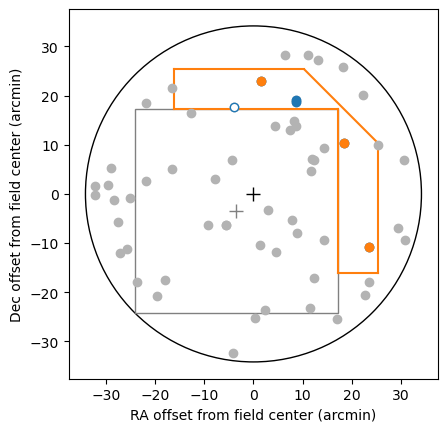

In [39]:
selector.visualize_selection(coord_rot_guidestars, coord_rot_guidearea, coord_rot_edge, coord_rot_circle, coord_rot_avoid);

In [40]:
guidestars

[{'guidestar_ra': 1.585535309456856,
  'guidestar_dec': -1.0493027032468438,
  'guidestar_mag': 11.140527,
  'cam_pos_x': 7.726661465246277,
  'cam_pos_y': 157.07306298705294},
 {'guidestar_ra': 1.5824417212602868,
  'guidestar_dec': -1.0431734469465221,
  'guidestar_mag': 11.464241,
  'cam_pos_x': 29.916837484688724,
  'cam_pos_y': 65.2216347925841},
 {'guidestar_ra': 1.5727135743352825,
  'guidestar_dec': -1.0395099503261083,
  'guidestar_mag': 11.836547,
  'cam_pos_x': 103.08084209233567,
  'cam_pos_y': 10.098279067915671}]

### Test different instrument orientation

Above we assume the instrument is mounted such that the guide area is located North and East of the science field. In the following we assume the instrument is tilted by 90 degrees clockwise, such that the guide area is located East and South of the science field:

In [41]:
selector.set_params(
        circle_radius, circle_offset, field_size, cam_size, guide_area, home_pos, instr_rot=np.pi/2, limit=limit, scale=scale, 
        scale_xy=scale_xy, n_min=n_min, n_max=n_max)

In [42]:
field_center = SkyCoord(90, -60, unit='deg')
guidestars, coord_rot_guidestars, coord_rot_guidearea, coord_rot_edge, coord_rot_circle, coord_rot_avoid = selector.select(
    field_ra=field_center.ra.rad, field_dec=field_center.dec.rad, return_coord=True)

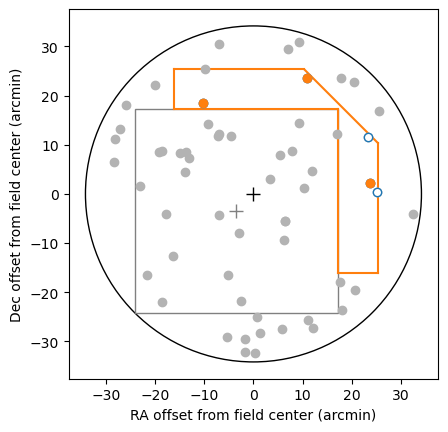

In [43]:
selector.visualize_selection(coord_rot_guidestars, coord_rot_guidearea, coord_rot_edge, coord_rot_circle, coord_rot_avoid);

### Calculate exposure times 

We implement the magnitude-to-exposure time function in a lambda function and hand it to the `select()` method. Then it will be automatically applied to each guidestar:

In [44]:
mag_ref = 16
exp_ref = 5 # sec
exp_min = 1 # sec
mag_to_exp = lambda mag: np.maximum(exp_ref * 10**((mag - mag_ref) / 2.5), exp_min)

In [45]:
guidestars = selector.select(field_ra=field_center.ra.rad, field_dec=field_center.dec.rad, mag_to_exp=mag_to_exp)
guidestars

[{'guidestar_ra': 1.5731277710022162,
  'guidestar_dec': -1.0530685723159916,
  'guidestar_mag': 10.542655,
  'cam_pos_x': 7.24179437056812,
  'cam_pos_y': 100.1773582781302,
  'exp': 1.0},
 {'guidestar_ra': 1.585535309456856,
  'guidestar_dec': -1.0493027032468438,
  'guidestar_mag': 11.140527,
  'cam_pos_x': 62.925835014874394,
  'cam_pos_y': 7.7271686797701085,
  'exp': 1.0},
 {'guidestar_ra': 1.5824417212602868,
  'guidestar_dec': -1.0431734469465221,
  'guidestar_mag': 11.464241,
  'cam_pos_x': -93758.26447031958,
  'cam_pos_y': 29.91719686925884,
  'exp': 1.0}]

### Select guide stars for field grid

Create Southern field grid:

In [46]:
grid = FieldGridIsoLat(verbose=1)
grid.load_params('grid_test_s.json')

Create fields..
    Done                                                    
Final number of fields: 547
Grid parameters loaded from grid_test_s.json.


In [47]:
guidestars = selector.select(fieldgrid=grid)

Iterate through field grid..
  done.                             


Results:
--------------------------------------------
Guide stars selected:           1242
Fields without guide stars:       55 (10.1%)
--------------------------------------------
Median number of field stars:      3
Mean number of field stars:        2
Max number of field stars:         3


In [48]:
selector.check_results(verbose=2)

Results:
--------------------------------------------
Guide stars selected:           1242
Fields without guide stars:       55 (10.1%)
--------------------------------------------
Median number of field stars:      3
Mean number of field stars:        2
Max number of field stars:         3
--------------------------------------------
No. of guide stars: No. of fields
 0:  55
 1:  72
 2:  90
 3: 330
--------------------------------------------


### Add higher magnitude stars

Add stars with higher magnitudes and automatically update guide collections for fields, where not enough are available yet:

In [49]:
dir_in = 'gaia/'
votable_files = 'gaia_g_mag12-13_b28.vot'

gaia_ra, gaia_dec, gaia_mag = load_gaia(votable_files, dir_in, dec_uplim=1)
print('# stars:', gaia_mag.shape[0])

Read VOTable 1/1..
# stars: 478881


Add stars:

In [50]:
selector.set_stars(np.radians(gaia_ra), np.radians(gaia_dec), gaia_mag)

Overwriting previous stars..
478881 candidate stars added.
Magnitude range: 12.0 - 13.0

127 field do not have enough guide stars. Search for more..
  done.                             


Results:
--------------------------------------------
Guide stars selected:           1348
Fields without guide stars:       35 (6.4%)
--------------------------------------------
Median number of field stars:      3
Mean number of field stars:        2
Max number of field stars:         3


In [51]:
selector.check_results(verbose=2)

Results:
--------------------------------------------
Guide stars selected:           1348
Fields without guide stars:       35 (6.4%)
--------------------------------------------
Median number of field stars:      3
Mean number of field stars:        2
Max number of field stars:         3
--------------------------------------------
No. of guide stars: No. of fields
 0:  35
 1:   6
 2: 176
 3: 330
--------------------------------------------


### Avoid bright stars

Create class instance add load parameters:

In [52]:
selector = GuideStarWalopS()

In [53]:
selector.load_params('guide_walop_s.json')

Parameters loaded from guide_walop_s.json.


Load Gaia stars:

In [54]:
dir_in = 'gaia/'
votable_files = 'gaia_g_mag12_b28.vot'

gaia_ra, gaia_dec, gaia_mag = load_gaia(votable_files, dir_in, dec_uplim=1)
gaia_coord = SkyCoord(gaia_ra, gaia_dec, unit='deg')

print('# stars:', gaia_mag.shape[0])

Read VOTable 1/1..
# stars: 419381


Separate bright stars:

In [55]:
gaia_mag_limit = 7
sel = gaia_mag < gaia_mag_limit
gaia_bright_ra = gaia_ra[sel]
gaia_bright_dec = gaia_dec[sel]
gaia_ra = gaia_ra[~sel]
gaia_dec = gaia_dec[~sel]
gaia_coord = gaia_coord[~sel]
gaia_mag = gaia_mag[~sel]
print(f'{np.sum(sel)} bright stars separated.')

4383 bright stars separated.


Add bright stars that should be avoided:

In [56]:
selector.set_stars_to_avoid(np.radians(gaia_bright_ra), np.radians(gaia_bright_dec))

4383 coordinates of bright stars set that will be avoided in the guide camera.


Add stars:

In [57]:
selector.set_stars(np.radians(gaia_ra), np.radians(gaia_dec), gaia_mag)

414998 candidate stars added.
Magnitude range: 7.0 - 12.0


Demonstrate on a specific sky location:

In [58]:
field_center = SkyCoord(90, -60, unit='deg')
guidestars, coord_rot_guidestars, coord_rot_guidearea, coord_rot_edge, coord_rot_circle, coord_rot_avoid = selector.select(
    field_ra=field_center.ra.rad, field_dec=field_center.dec.rad, return_coord=True)

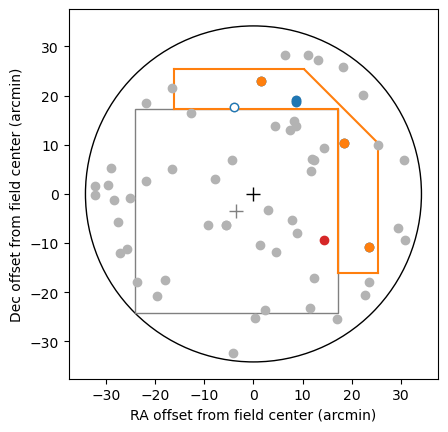

In [59]:
selector.visualize_selection(coord_rot_guidestars, coord_rot_guidearea, coord_rot_edge, coord_rot_circle, coord_rot_avoid);

Run for field grid:

In [60]:
grid = FieldGridIsoLat(verbose=1)
grid.load_params('grid_test_s.json')

Create fields..
    Done                                                    
Final number of fields: 547
Grid parameters loaded from grid_test_s.json.


In [61]:
guidestars = selector.select(fieldgrid=grid)

Iterate through field grid..
  done.                             


Results:
--------------------------------------------
Guide stars selected:           1275
Fields without guide stars:       53 (9.7%)
--------------------------------------------
Median number of field stars:      3
Mean number of field stars:        2
Max number of field stars:         3


In [62]:
selector.check_results(verbose=2)

Results:
--------------------------------------------
Guide stars selected:           1275
Fields without guide stars:       53 (9.7%)
--------------------------------------------
Median number of field stars:      3
Mean number of field stars:        2
Max number of field stars:         3
--------------------------------------------
No. of guide stars: No. of fields
 0:  53
 1:  52
 2: 103
 3: 339
--------------------------------------------


Add stars with higher magnitudes and automatically update guide collections for fields, where not enough are available yet:

In [63]:
dir_in = 'gaia/'
votable_files = 'gaia_g_mag12-13_b28.vot'

gaia_ra, gaia_dec, gaia_mag = load_gaia(votable_files, dir_in, dec_uplim=1)

print('# stars:', gaia_mag.shape[0])

Read VOTable 1/1..
# stars: 478881


Add stars:

In [64]:
selector.set_stars(np.radians(gaia_ra), np.radians(gaia_dec), gaia_mag)

Overwriting previous stars..
478881 candidate stars added.
Magnitude range: 12.0 - 13.0

105 field do not have enough guide stars. Search for more..
  done.                             


Results:
--------------------------------------------
Guide stars selected:           1354
Fields without guide stars:       35 (6.4%)
--------------------------------------------
Median number of field stars:      3
Mean number of field stars:        2
Max number of field stars:         3


In [65]:
selector.check_results(verbose=2)

Results:
--------------------------------------------
Guide stars selected:           1354
Fields without guide stars:       35 (6.4%)
--------------------------------------------
Median number of field stars:      3
Mean number of field stars:        2
Max number of field stars:         3
--------------------------------------------
No. of guide stars: No. of fields
 0:  35
 1:   9
 2: 164
 3: 339
--------------------------------------------
